In [8]:
# Import libraries
import pandas as pd
import numpy as np
import pandas_ta as ta
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go

In [9]:
timeframe = "M15"
symbols = ["SPX500"]
systems = ["Strat"]#, "BuyHold", "Random"]
starting_balance = 100
risk_per_trade = 0.02 # Risking 2% per trade
market_open_time = "09:30"
market_close_time = "16:45"
latest_entry_time = "15:59"
exit_eod = False
slow_ema = 200
consecutive = 5  # Number of candles Lips must be below/above Teeth before crossing
trade_direction = "long"

In [10]:
# Load CSV File
def get_price_data(symbol):
    df = pd.read_csv(f"../data/{symbol}_{timeframe}.csv", parse_dates=['Datetime'], index_col='Datetime')
    df.index = pd.to_datetime(df.index, utc=True).tz_convert("America/New_York")  # Keeps local timezone without converting to UTC
    return df

In [11]:
def calculate_inputs(df):

    def smma(series, length):
        smma_values = []
        smma_prev = series.rolling(window=length).mean().iloc[length-1]  # First value as SMA
        smma_values.append(smma_prev)

        for price in series[length:]:
            smma_new = (smma_prev * (length - 1) + price) / length
            smma_values.append(smma_new)
            smma_prev = smma_new

        return pd.Series([None] * (length-1) + smma_values, index=series.index)
    
    df['Median_Price'] = (df['High'] + df['Low']) / 2

    df['Jaw'] = smma(df['Median_Price'], 13).shift(8)
    df['Teeth'] = smma(df['Median_Price'], 8).shift(5)
    df['Lips'] = smma(df['Median_Price'], 5).shift(3)

    # Lips Below Teeth for consecutive Candles Before Crossing Above
    df['Lips_Below_Teeth'] = df['Lips'] < df['Teeth']
    df['Lips_Below_Teeth_Streak'] = df['Lips_Below_Teeth'].rolling(window=consecutive).sum() == consecutive

    # Lips Above Teeth for consecutive Candles Before Crossing Below
    df['Lips_Above_Teeth'] = df['Lips'] > df['Teeth']
    df['Lips_Above_Teeth_Streak'] = df['Lips_Above_Teeth'].rolling(window=consecutive).sum() == consecutive

    df["Slow_EMA"] = df["Close"].ewm(span=slow_ema, adjust=False).mean()

    df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

    df['Swing_Low'] = df['Low'].rolling(window=10).min()

    # Ensure the Datetime column is a datetime object
    df.index = pd.to_datetime(df.index)
    df['Date'] = df.index.date
    df['Time'] = df.index.time
    df['Last_Candle'] = df['Date'] != df['Date'].shift(-1)

    # Drop the 'Time' and 'Date' columns if no longer needed
    df = df.drop(['Time', 'Date'], axis=1)

    return df

In [12]:
def generate_signals(df, s, atr_sl, tp_ratio):
    
    # Various entry conditions
    c1_long = (df['Lips'] > df['Teeth']) & (df['Lips'].shift(1) < df['Teeth'].shift(1))
    c2_long = df['Close'] > df['Slow_EMA']
    c3_long = df['Lips_Below_Teeth_Streak'].shift(1)

    c1_long_alt = df['Lips'] < df['Teeth']
    c2_long_alt = df['Close'] > df['Teeth']
    c3_long_alt = df['Close'] > df['Slow_EMA']

    c1_short = (df['Lips'] < df['Teeth']) & (df['Lips'].shift(1) > df['Teeth'].shift(1))
    c2_short = df['Close'] < df['Slow_EMA']
    c3_short = df['Lips_Above_Teeth_Streak'].shift(1)

    c4 = df['ATR'].notna()

    #generate entries and exits
    #entry is taken if the conditions were met at yesterday's close
    # Entries depend on the strategy
    if s == "Strat":
        # default entry rules
        if trade_direction == "long":
            df[f"{s}_Signal"] = c1_long.shift(1) & c2_long.shift(1) & c4.shift(1) # default strategy rules
            #df[f"{s}_Signal"] = c1_long_alt.shift(1) & c2_long_alt.shift(1) & c3_long_alt.shift(1) & c4.shift(1)# & c4 & c5 # data trader and tradeIQ strategy rules
        elif trade_direction == "short":
            df[f"{s}_Signal"] = c1_short.shift(1) & c2_short.shift(1) & c4.shift(1)# default strategy rules
    elif s == "Random":
        num_true = 3200
        num_false = len(df) - 15 - num_true
        signals = [True] * num_true + [False] * num_false
        np.random.shuffle(signals)
        signals = [False] * 15 + signals
        df[f"{s}_Signal"] = signals
    elif s == "BuyHold":
        df[f"{s}_Signal"] = True

    if trade_direction == "long":
        # Compute ATR-based Stop Loss
        df['SL'] = df['Open'] - df['ATR'].shift(1) * atr_sl # ATR based stop
        #df['SL'] = df['Swing_Low'] # Swing Low based stop
        stop_dist = df['Open'] - df['SL']
        df['TP'] = df['Open'] + stop_dist * tp_ratio

        #df['Exit'] = df['Close'] < df['Lips']

    elif trade_direction == "short":
        df['SL'] = df['Open'] + df['ATR'].shift(1) * atr_sl
        stop_dist = df['SL'] - df['Open']
        df['TP'] = df['Open'] - stop_dist * tp_ratio
   
    return df

In [13]:
def generate_trades(df, s):
    if s == "BuyHold":
        #calculate benchmark return and balance
        df[f"{s}_Trade"] = True
        df[f"{s}_In_Market"] = True
        df[f"{s}_Ret"] = df.Close / df.Close.shift(1)
        df[f"{s}_Ret"].iat[0] = 1
        df[f"{s}_Bal"] = starting_balance * df[f"{s}_Ret"].cumprod()
        df[f"{s}_Running_Bal"] = df[f"{s}_Bal"]
        df[f"{s}_Entry_Price"] = df.Close
        
        return df, None
    else:
        #create empty list for trades
        trades_list = []
        trade_open = False
        open_change = {}
        balance = starting_balance
        equity = starting_balance
        balance_history = []
        equity_history = []
        
        #iterate through rows to work out entries and exits
        for i, row in df.iterrows():
            #if there is currently no trade
            if not trade_open:
                #check if long signal was generated and enter at the same time
                if row[f"{s}_Signal"] == True:
                    entry_date = i
                    entry_price = row.Open
                    sl = row.SL
                    tp = row.TP
                    high = row.High
                    close = row.Close
                    # Calculate position size based on risk percentage
                    risk_amount = balance * risk_per_trade
                    if entry_price == sl:
                        position_size = 0.01
                    else:
                        position_size = risk_amount / abs(entry_price - sl)  # Position size in units
                    trade_open = True
            #check if a trade is already open
            if trade_open:
                #get price values
                prev_close = close
                low = row.Low
                high = row.High
                close = row.Close

                # Calculate unrealized PnL
                if trade_direction == "long":
                    floating_pnl = (high - entry_price) * position_size
                    equity = balance + floating_pnl  # Update equity dynamically

                    # Calculate unrealized PnL
                    #check if stop is hit
                    if low <= sl:
                        #first check for a gap down
                        if row.Open <= sl:
                            exit_price = row.Open
                        else:
                            exit_price = sl
                        trade_open = False

                    # Now do the same check for take profit
                    elif high >= tp:
                        #first check for a gap up
                        if row.Open >= tp:
                            exit_price = row.Open
                        else:
                            exit_price = tp
                        trade_open = False

                    elif getattr(row, "Exit", False):
                        exit_price = row.Close  # Close at the market close price
                        trade_open = False
                    
                    elif exit_eod:
                        if (i.time() == datetime.strptime(market_close_time, '%H:%M').time()) or row.Last_Candle:
                            exit_price = row.Close  # Close at the market close price
                            trade_open = False

                elif trade_direction == "short":
                    floating_pnl = (entry_price - low) * position_size
                    equity = balance + floating_pnl  # Update equity dynamically

                    # Calculate unrealized PnL
                    #check if stop is hit
                    if high >= sl:
                        #first check for a gap down
                        if row.Open >= sl:
                            exit_price = row.Open
                        else:
                            exit_price = sl
                        trade_open = False

                    # Now do the same check for take profit
                    elif low <= tp:
                        #first check for a gap up
                        if row.Open <= tp:
                            exit_price = row.Open
                        else:
                            exit_price = tp
                        trade_open = False

                    elif getattr(row, "Exit", False):
                        exit_price = row.Close  # Close at the market close price
                        trade_open = False

                    elif exit_eod:
                        if (i.time() == datetime.strptime(market_close_time, '%H:%M').time()) or row.Last_Candle:
                            exit_price = row.Close  # Close at the market close price
                            trade_open = False

                if not trade_open: # If trade has been closed
                    exit_date = i
                    trade_open = False
                    if trade_direction == "long":
                        pnl = (exit_price - entry_price) * position_size  # PnL in currency terms
                    elif trade_direction == "short":
                        pnl = -1 * (exit_price - entry_price) * position_size  # PnL in currency terms
                    balance += pnl  # Update balance with PnL

                    #store trade data in a list
                    trade = [entry_date, entry_price, exit_date, exit_price, position_size, pnl, balance, True]
                    #append trade to overall trade list
                    trades_list.append(trade)

            # Store balance and equity
            balance_history.append(balance)
            equity_history.append(equity)

        trades = pd.DataFrame(trades_list, columns=["Entry_Date", "Entry_Price", "Exit_Date", "Exit_Price", "Position_Size", "PnL", "Balance", "Sys_Trade"])
        
        #calculate return of each trade as well as the trade duration
        #trades[f"{s}_Return"] = trades.Exit_Price / trades.Entry_Price
        trades[f"{s}_Return"] = trades.Balance / trades.Balance.shift(1)
        dur = []
        for i, row in trades.iterrows():
            d1 = row.Entry_Date
            d2 = row.Exit_Date
            dur.append(np.busday_count(d1.date(), d2.date()) + 1)#Add 1 because formula doesn't include the end date otherwise
        
        trades[f"{s}_Duration"] = dur

        #create a new dataframe with an index of exit dfs
        returns = pd.DataFrame(index=trades.Exit_Date)
        #create a new dataframe with an index of entries to track entry price
        entries = pd.DataFrame(index=trades.Entry_Date)

        entries[f"{s}_Entry_Price"] = pd.Series(trades.Entry_Price).values
        #add the Return column to this new data frame
        returns[f"{s}_Ret"] = pd.Series(trades[f"{s}_Return"]).values
        returns[f"{s}_Trade"] = pd.Series(trades.Sys_Trade).values
        returns[f"{s}_Duration"] = pd.Series(trades[f"{s}_Duration"]).values
        returns[f"{s}_PnL"] = pd.Series(trades.PnL).values
        returns[f"{s}_Balance"] = pd.Series(trades.Balance).values

        #add the returns from the trades to the main data frame
        df = pd.concat([df, returns, entries], axis=1)
        #fill all the NaN return values with 1 as there was no profit or loss on those days
        df[f"{s}_Ret"] = df[f"{s}_Ret"].fillna(1)
        #fill all the NaN trade values with False as there was no trade on those days
        df[f"{s}_Trade"] = df[f"{s}_Trade"].infer_objects(copy=False)
        
        #use the updated balance and equity variables
        df[f"{s}_Bal"] = pd.Series(balance_history, index=df.index).ffill()
        df[f"{s}_Equity"] = pd.Series(equity_history, index=df.index).ffill()

        active_trades = np.where(df[f"{s}_Trade"] == True, True, False)
        df[f"{s}_In_Market"] = df[f"{s}_Trade"].copy()
        #populate trades column based on duration
        for count, t in enumerate(active_trades):
            if t == True:
                dur = df[f"{s}_Duration"].iat[count]
                for i in range(int(dur)):
                    #starting from the exit date, move backwards and mark each trading day
                    df[f"{s}_In_Market"].iat[count - i] = True
    
        return df, trades

In [14]:
def backtest(price, sl, tp_ratio):
    #calculate strategy inputs
    price = calculate_inputs(price)

    for s in systems:
        #generate signals
        price = generate_signals(price, s, sl, tp_ratio)

        #generate trades
        price, trades = generate_trades(price, s)

    for s in systems:
        #calculate drawdown
        price[f"{s}_Peak"] = price[f"{s}_Bal"].cummax()
        price[f"{s}_DD"] = price[f"{s}_Bal"] - price[f"{s}_Peak"]

    return price, trades

In [15]:
results = []
result_keys = []
result_key = ""
prog = 0
sl_range = np.arange(1.0, 1.5, 0.5)
tp_range = np.arange(3.0, 3.5, 0.5)
max_prog = len(symbols) * len(sl_range) * len(tp_range)
start_time = time.time()
for sym in symbols:
    price = get_price_data(sym)
    for sl in sl_range:
        for tp_ratio in tp_range:
            result, trades = backtest(price, sl, tp_ratio)
            results.append(result)
            result_key = f"{sym}_sl{sl}_tp{tp_ratio}"  # String format
            result_keys.append(result_key)
            prog += 1
            clear_output(wait=True)
            print(f"Progress: {round((prog / max_prog) * 100)} %")
end_time = time.time()
print(f"Total Time Elapsed: {end_time - start_time} s")

Progress: 100 %
Total Time Elapsed: 3.439023494720459 s


In [16]:
def get_metrics(system, data):
    rfr = 0.03 # risk free return rate of 3%
    if timeframe == "daily":
        N = 252 # number of trading days per year
    elif timeframe == "hourly":
        N = 252 * 6.5 # number of trading hours per year (assuming 9:30 - 16:00 for NYSE)
    elif timeframe == "M30":
        N = 252 * 6.5 * 2       
    elif timeframe == "M15":
        N = 252 * 6.5 * 4
    elif timeframe == "M5":
        N = 252 * 6.5 * 12
    metrics = {}
    years = (data.index[-1] - data.index[0]).days / 365.25
    sys_return = round(((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0]) - 1) * 100, 2)
    sys_cagr = round(((((data[f"{system}_Bal"].iloc[-1]/data[f"{system}_Bal"].iloc[0])**(1/years))-1)*100), 2)
    sys_peak = data[f"{system}_Bal"].cummax()
    sys_dd = round(((data[f"{system}_DD"] / data[f"{system}_Peak"]).min()) * 100, 2)
    rod = sys_cagr / abs(sys_dd)
    periods_in_market = data[f"{system}_In_Market"].sum()
 
    win = data[f"{system}_Ret"] > 1
    loss = data[f"{system}_Ret"] < 1
    signals = data[f"{system}_Signal"].sum()
    trades_triggered = data[f"{system}_Trade"].sum()
    tim = round(periods_in_market / len(data) * 100, 2)
    rbe = round((sys_cagr / tim) * 100, 2)
    rbeod = rbe / abs(sys_dd) # return by exposure by drawdown (assuming drawdown doesn"t scale as TIM increases. Could be wrong)
    gaps = (data.Open > data[f"{system}_Entry_Price"]).sum()
    non_gaps = (data.Open <= data[f"{system}_Entry_Price"]).sum()
    wins = win.sum()
    losses = loss.sum()
    winrate = round(wins / (wins + losses) * 100, 2)
    
    # calculate the size of the move from the entry data to the close
    ret_size = np.where(data[f"{system}_Trade"] == True, data[f"{system}_Ret"], 1)
    avg_up_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] > 1].mean() - 1) * 100
    max_up_move = (data[f"{system}_Ret"].max() - 1) * 100
    avg_down_move = (data[f"{system}_Ret"][data[f"{system}_Ret"] < 1].mean() - 1) * 100
    max_down_move = (data[f"{system}_Ret"].min() - 1) * 100
    avg_rr = round(abs(avg_up_move / avg_down_move), 2)

    #sharpe ratio
    ret = data[f"{system}_Bal"].pct_change().dropna()
    excess_ret = ret - rfr/N
    sharpe = np.sqrt(N) * excess_ret.mean() / excess_ret.std()

    #sortino ratio
    downside_std = excess_ret[excess_ret < 0].std()
    sortino = np.sqrt(N) * excess_ret.mean() / downside_std
        
    # Calculate longest trade and average trade duration
    longest_trade_duration = 0
    avg_trade_duration = 0
    if f"{system}_Duration" in data:
        longest_trade_duration = data[f"{system}_Duration"].max()
        avg_trade_duration = data[f"{system}_Duration"].mean()

    #save data
    metrics["Start_Balance"] = round(data[f"{system}_Bal"].iat[0], 2)
    metrics["Final_Balance"] = round(data[f"{system}_Bal"].iat[-1], 2)
    #metrics["Total_Return"] = round(sys_return, 2)
    metrics["Annual_Return"] = round(sys_cagr, 2)
    #metrics["Time_in_Market"] = round(tim, 2)
    #metrics["Return_By_Exposure"] = rbe
    metrics["Max_Drawdown"] = round(sys_dd, 2)
    #metrics["Return_Over_Drawdown"] = round(rod, 2)
    #metrics["RBE_Over_Drawdown"] = round(rbeod, 2)
    metrics["Sharpe"] = round(sharpe, 2)
    metrics["Sortino"] = round(sortino, 2)
    metrics["Signals"] = round(signals, 2)
    metrics["Trades"] = round(trades_triggered, 2)
    
    #metrics["Gap"] = round(gaps)
    #metrics["No_Gap"] = round(non_gaps)
    #metrics["Wins"] = round(wins, 2)
    #metrics["Losses"] = round(losses, 2)
    metrics["Winrate"] = round(winrate, 2)
    #metrics["Max_Trade_Return_pct"] = round(max_up_move, 2)
    #metrics["Max_Trade_Loss_pct"] = round(max_down_move, 2)
    #metrics["Avg_Trade_Return_pct"] = round(avg_up_move, 2)
    #metrics["Avg_Trade_Loss_pct"] = round(avg_down_move, 2)
    metrics["Avg_RR"] = avg_rr

    # Add Longest and Average Trade Duration
    metrics["Longest_Trade_Duration"] = longest_trade_duration
    #metrics["Avg_Trade_Duration"] = round(avg_trade_duration, 2)

    return metrics

In [17]:
sys_metrics = {}
for count, res in enumerate(results):
    for s in systems:
        for sl in sl_range:
            for tp_ratio in tp_range:
                sys_metrics[f"{s}_{result_keys[count]}"] = get_metrics(s, res)
    sys_metrics_df = pd.DataFrame.from_dict(sys_metrics)

In [18]:
def show_trades(df, trades, start_date=None, end_date=None, trade_number=None):

    # Ensure datetime index with timezone awareness
    df.index = pd.to_datetime(df.index).tz_convert('America/New_York')
    trades['Entry_Date'] = pd.to_datetime(trades['Entry_Date']).dt.tz_convert('America/New_York')
    trades['Exit_Date'] = pd.to_datetime(trades['Exit_Date']).dt.tz_convert('America/New_York')

    # If start_date is provided, filter the trades dataframe to only include trades after the start_date
    if start_date:
        start_date = pd.Timestamp(start_date, tz='America/New_York')
        trades = trades[trades['Entry_Date'] >= start_date]
        trades = trades[trades['Exit_Date'] >= start_date]  # Ensure exit date is also after the start_date
    
    # If trade_number is specified, filter the data based on that trade's entry and exit dates
    if trade_number is not None:
        # Get the specific trade's entry and exit dates using iloc to avoid KeyError after filtering
        trade_entry_date = trades.iloc[trade_number]['Entry_Date']
        trade_exit_date = trades.iloc[trade_number]['Exit_Date']
        
        # Extend the date range by 1 day before entry and 1 day after exit
        extended_start_date = trade_entry_date - pd.Timedelta(days=1)
        extended_end_date = trade_exit_date + pd.Timedelta(days=1)

        # Filter the price data (df) and trades data by the extended entry and exit dates
        df = df[(df.index >= extended_start_date) & (df.index <= extended_end_date)]
        trades = trades[(trades['Entry_Date'] >= extended_start_date) & (trades['Exit_Date'] <= extended_end_date)]
    else:
        # If no trade_number is passed, apply the global date range filters
        if start_date:
            df = df[df.index >= start_date]
            trades = trades[trades['Entry_Date'] >= start_date]
        if end_date:
            end_date = pd.Timestamp(end_date, tz='America/New_York')
            df = df[df.index <= end_date]
            trades = trades[trades['Exit_Date'] <= end_date]

    # Create buy and sell signals from trades dataframe
    buy_signals = pd.DataFrame({
        'date': trades['Entry_Date'],
        'price': trades['Entry_Price']
    }).set_index('date')

    sell_signals = pd.DataFrame({
        'date': trades['Exit_Date'],
        'price': trades['Exit_Price']
    }).set_index('date')
    
    # Create the figure
    fig = go.Figure()

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='Candlestick',
        increasing_line_color='green',
        decreasing_line_color='red'
    ))

    # Plot buy and sell signals
    fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['price'], 
                             mode='markers+text', marker=dict(symbol='diamond', color='green', size=12, line=dict(color='black', width=2)), 
                             name='Buy Signal', text='BUY', textposition='bottom center', 
                             textfont=dict(size=14, color='black', family='Arial', weight='bold')))
    fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['price'], 
                             mode='markers+text', marker=dict(symbol='diamond', color='red', size=12, line=dict(color='black', width=2)),
                             name='Sell Signal', text='SELL', textposition='top center', 
                             textfont=dict(size=14, color='black', family='Arial', weight='bold')))

    # Customize layout for panning and zooming
    fig.update_layout(
        title='Candlestick Chart with Indicators and Trade Signals',
        xaxis_title='Datetime',
        yaxis_title='Price',
        xaxis_rangeslider_visible=True,  # Enable range slider
        height=900,
        autosize=True,  # Enable auto resize for the chart
        margin={'l': 50, 'r': 50, 't': 60, 'b': 60},  # Add margins around the chart
        showlegend=True,
        xaxis=dict(
            type='category',  # Treat the x-axis as categorical to remove gaps
            rangeslider=dict(visible=True),  # Rangeslider visible for easier panning
            fixedrange=False,  # Disable zooming with the mouse wheel, only panning allowed
        ),
        yaxis=dict(
            fixedrange=False,  # Allow zooming on y-axis too
        ),
    )

    fig.show()

In [19]:
# if trades is not None:
#     show_trades(price, trades, start_date="2020, 1, 1", trade_number=0)

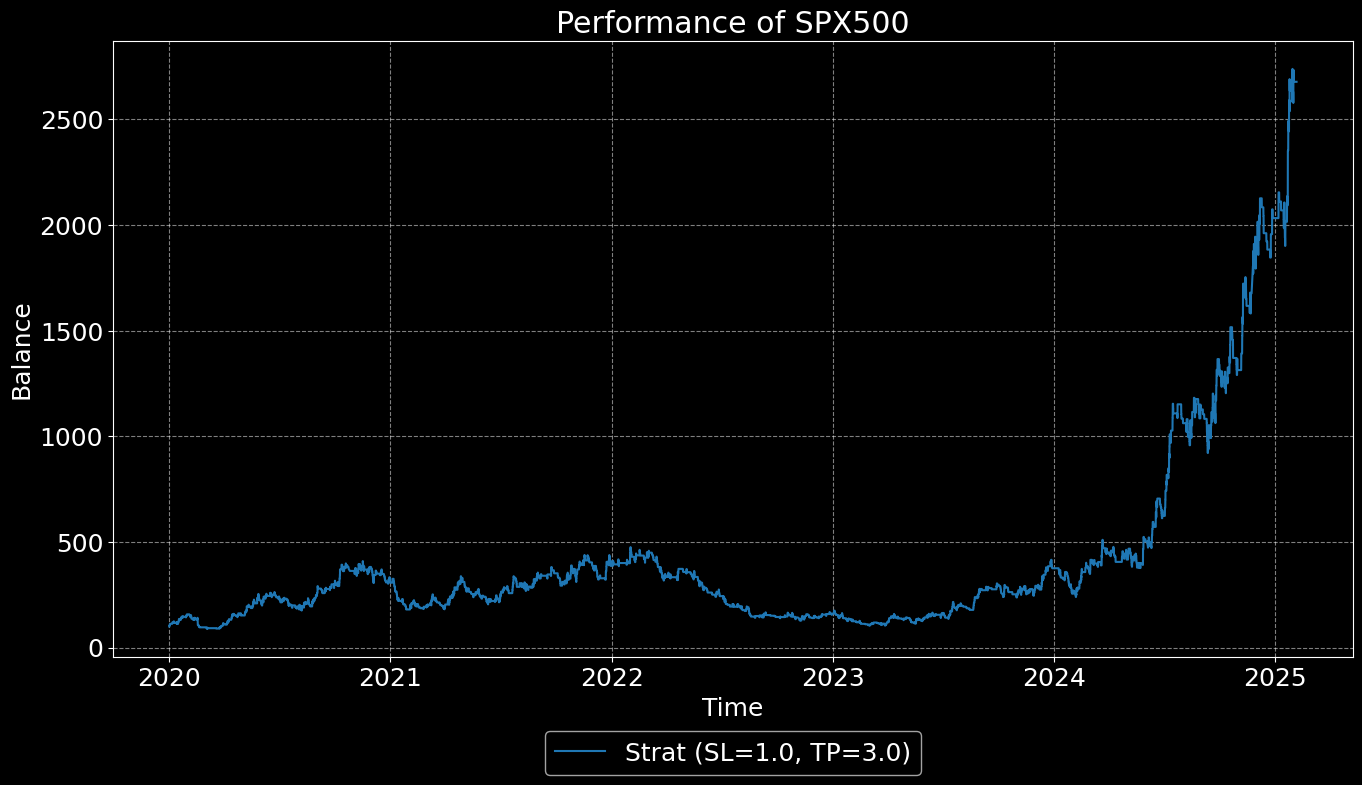

In [29]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams.update({"font.size": 18})

#colours = ["tab:olive", "tab:blue", "tab:purple", "tab:orange", "tab:green", "tab:cyan", "tab:red", "tab:gray", "tab:pink"]
cmap = plt.get_cmap("tab10")  # You can try 'tab20', 'viridis', 'plasma', etc.

for count, sym in enumerate(symbols):
    plt.figure()
    plt.title(f"Performance of {sym}")

    legend_entries = []  # Store legend labels
    total_lines = len(tp_range) * len(sl_range) * len(systems)  # Total lines to plot
    colours = [cmap(i / total_lines) for i in range(total_lines)]  # Generate distinct colors
    
    colour_idx = 0  # To cycle through colors if needed

    for sl in sl_range:
        for tp_ratio in tp_range:
            for c, s in enumerate(systems):
                # Generate a unique index for each (SL, TP) combination
                result_idx = count * len(sl_range) * len(tp_range) + list(sl_range).index(sl) * len(tp_range) + list(tp_range).index(tp_ratio)

                if result_idx >= len(results):  
                    continue  # Prevent out-of-bounds error

                label = f"{s} (SL={sl}, TP={tp_ratio})"  # Legend label
                color = colours[colour_idx % len(colours)]  # Cycle through colors
                
                plt.plot(results[result_idx][f"{s}_Bal"], color=color, label=label)
                legend_entries.append(label)

                colour_idx += 1  # Move to next color

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.xlabel("Time")
    plt.ylabel("Balance")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.savefig("plot.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()




In [21]:
print(sys_metrics_df.to_string())

                        Strat_SPX500_sl1.0_tp3.0
Start_Balance                             100.00
Final_Balance                            2678.35
Annual_Return                              90.65
Max_Drawdown                              -78.22
Sharpe                                      0.58
Sortino                                     1.20
Signals                                  2446.00
Trades                                   1939.00
Winrate                                    28.07
Avg_RR                                      2.97
Longest_Trade_Duration                      4.00


In [22]:
if trades is not None:
    # Split index into 'Date' and 'Time' columns
    trades['Entry_Date'] = pd.to_datetime(trades["Entry_Date"])
    trades['Entry_Hour'] = trades['Entry_Date'].dt.hour

    # Convert "Strat_Breakout_Return" to percentage
    trades["Return_Percentage"] = (trades[f"{systems[-1]}_Return"] - 1) * 100

    # Group by Hour and Calculate Average PnL
    hourly_return = trades.groupby("Entry_Hour")["Return_Percentage"].mean()

    # Group by Hour and Count Number of Trades
    hourly_trades_count = trades.groupby("Entry_Hour")["Return_Percentage"].count()

    # Combine the two results into a single DataFrame
    hourly_stats = pd.DataFrame({
        "Average_Return_Percentage": round(hourly_return, 2),
        "Trades_Count": hourly_trades_count
    })
    #pd.set_option('display.float_format', '{:.6f}'.format)
    # Display Result
    print(hourly_stats)

            Average_Return_Percentage  Trades_Count
Entry_Hour                                         
0                                1.33            48
1                                0.63            64
2                                0.00            76
3                               -0.36            78
4                                0.33           117
5                                0.45            88
6                                0.27            74
7                                0.54            85
8                               -0.14           103
9                                0.07           116
10                               0.70           145
11                               0.06           140
12                              -0.13           100
13                               0.61            95
14                              -0.30            99
15                               0.28            91
16                               0.24            76
18          

In [23]:
# Extract unique years
years = result.index.year.unique()

# Calculate returns
data = []
for year in result.index.year.unique():
    yearly_data = result[result.index.year == year]
    
    for system in systems:
        start_bal = yearly_data[f"{system}_Bal"].iloc[0]
        end_bal = yearly_data[f"{system}_Bal"].iloc[-1]
        return_pct = ((end_bal - start_bal) / start_bal) * 100
        data.append([year, system, return_pct])

# Convert to DataFrame
returns_df = pd.DataFrame(data, columns=["Year", "System", "Return"])



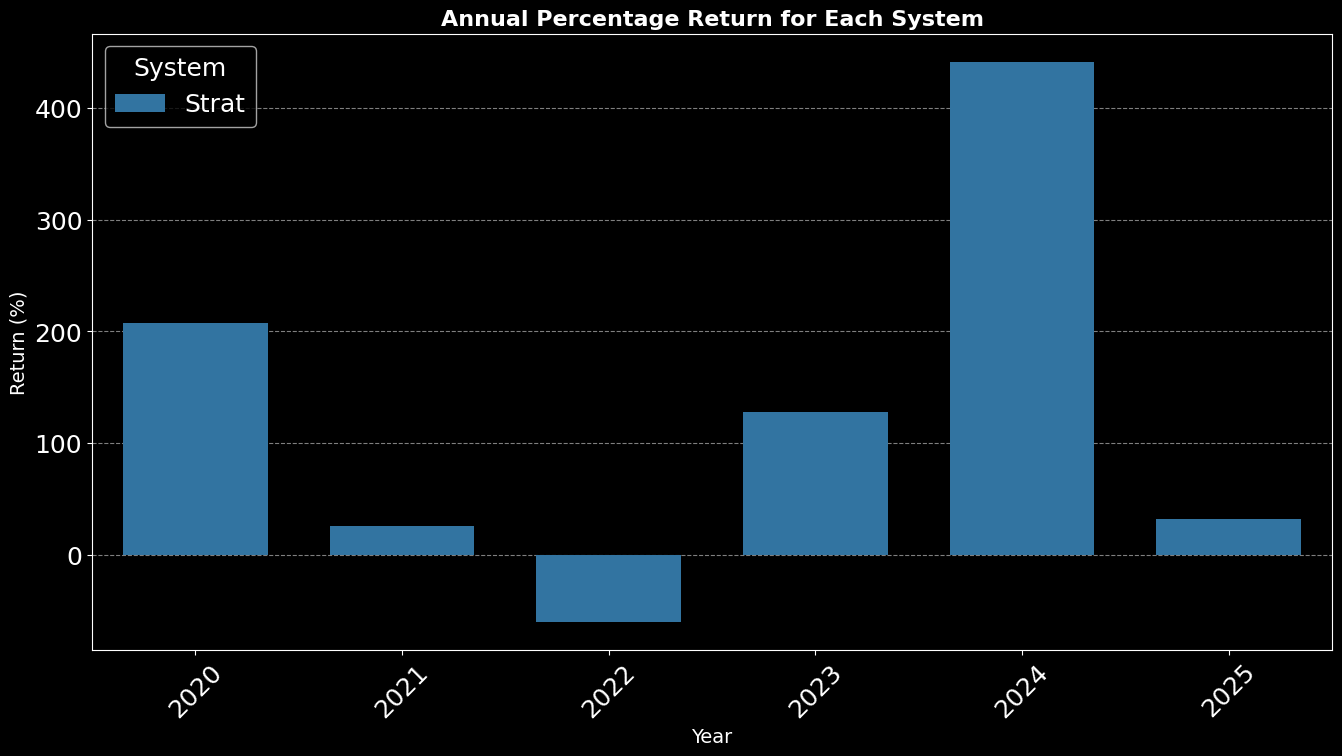

In [24]:
# Set up the figure
plt.figure(figsize=(16, 8))
sns.set_palette("tab10")

# Plot the bar chart
ax = sns.barplot(data=returns_df, x="Year", y="Return", hue="System", dodge=True, width=0.7)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add title and labels
plt.ylabel("Return (%)", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.title("Annual Percentage Return for Each System", fontsize=16, fontweight='bold')

# Gridlines
ax.set_axisbelow(True)
plt.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

# Legend
plt.legend(title="System", loc="upper left")

# Show the final chart
plt.show()


In [25]:
if trades is not None:
    trades.to_csv("trades.csv")
    result.to_csv("result.csv")

In [26]:
result

,Open,High,Low,Close,Volume,Median_Price,Jaw,Teeth,Lips,Lips_Below_Teeth,...,Strat_Trade,Strat_Duration,Strat_PnL,Strat_Balance,Strat_Entry_Price,Strat_Bal,Strat_Equity,Strat_In_Market,Strat_Peak,Strat_DD
2020-01-01 18:00:00-05:00,3236.6,3239.5,3235.0,3239.5,194,3237.25,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,0.000000
2020-01-01 18:15:00-05:00,3239.8,3240.9,3239.4,3240.8,77,3240.15,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,0.000000
2020-01-01 18:30:00-05:00,3240.6,3240.8,3238.8,3238.8,69,3239.80,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,0.000000
2020-01-01 18:45:00-05:00,3239.0,3239.4,3238.0,3238.0,38,3238.70,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,0.000000
2020-01-01 19:00:00-05:00,3238.2,3238.8,3237.6,3238.0,33,3238.20,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,100.000000,100.000000,NaN,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-04 21:00:00-05:00,6018.6,6020.6,6017.2,6020.2,423,6018.90,6024.927127,6025.807758,6025.989159,False,...,NaN,NaN,NaN,NaN,NaN,2678.353082,2723.332673,NaN,2739.413935,-61.060853
2025-02-04 21:15:00-05:00,6019.8,6019.8,6016.2,6018.0,378,6018.00,6024.809656,6025.881788,6025.611327,True,...,NaN,NaN,NaN,NaN,NaN,2678.353082,2678.353082,NaN,2739.413935,-61.060853
2025-02-04 21:30:00-05:00,6017.8,6020.2,6017.2,6019.8,239,6018.70,6024.993528,6026.196565,6024.629062,True,...,NaN,NaN,NaN,NaN,NaN,2678.353082,2681.850845,NaN,2739.413935,-61.060853
2025-02-04 21:45:00-05:00,6020.0,6021.0,6015.2,6015.8,231,6018.10,6025.124796,6025.934494,6023.483249,True,...,NaN,NaN,NaN,NaN,NaN,2678.353082,2688.846373,NaN,2739.413935,-61.060853
